<a href="https://colab.research.google.com/github/Royal-tek/HMS/blob/master/HARRY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import imblearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
import itertools
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, SimpleRNN, LSTM, Dropout, BatchNormalization, Flatten
import tensorflow as tf
import keras.backend as K
from sklearn.metrics import roc_curve, roc_auc_score
import itertools
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.decomposition import FastICA

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [23]:
#Load Data
train = pd.read_csv(r'/content/Train_data.csv')
test = pd.read_csv(r'/content/Test_data.csv')

In [24]:
print("Training data has {} rows & {} columns".format(train.shape[0],train.shape[1]))

print(test.head(4))

print("Testing data has {} rows & {} columns".format(test.shape[0],test.shape[1]))

train.describe()

#print(train['num_outbound_cmds'].value_counts())
#print(test['num_outbound_cmds'].value_counts())

#'num_outbound_cmds' is a redundant column so remove it from both train & test datasets
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)

# Attack Class Distribution
train['class'].value_counts()

Training data has 25192 rows & 42 columns
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp   private  REJ          0          0     0   
1         0           tcp   private  REJ          0          0     0   
2         2           tcp  ftp_data   SF      12983          0     0   
3         0          icmp     eco_i   SF         20          0     0   

   wrong_fragment  urgent  hot  ...  dst_host_count  dst_host_srv_count  \
0               0       0    0  ...             255                  10   
1               0       0    0  ...             255                   1   
2               0       0    0  ...             134                  86   
3               0       0    0  ...               3                  57   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.04                    0.06   
1                    0.00                    0.06   
2                    0.61                    0.04   
3        

normal     13449
anomaly    11743
Name: class, dtype: int64

In [25]:
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance  
cols = train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(test.select_dtypes(include=['float64','int64']))

# turn the result back to a dataframe
sc_traindf = pd.DataFrame(sc_train, columns = cols)
sc_testdf = pd.DataFrame(sc_test, columns = cols)

In [26]:
encoder = LabelEncoder()

# extract categorical attributes from both training and test sets 
cattrain = train.select_dtypes(include=['object']).copy()
cattest = test.select_dtypes(include=['object']).copy()

# encode the categorical attributes
traincat = cattrain.apply(encoder.fit_transform)
testcat = cattest.apply(encoder.fit_transform)

# separate target column from encoded data 
enctrain = traincat.drop(['class'], axis=1)
cat_Ytrain = traincat[['class']].copy()

In [27]:
#Union of processed numerical and categorical data
train_x = pd.concat([sc_traindf,enctrain],axis=1)
train_y = cat_Ytrain
train_x.shape

test_df = pd.concat([sc_testdf,testcat],axis=1)
test_df.shape

(22544, 40)

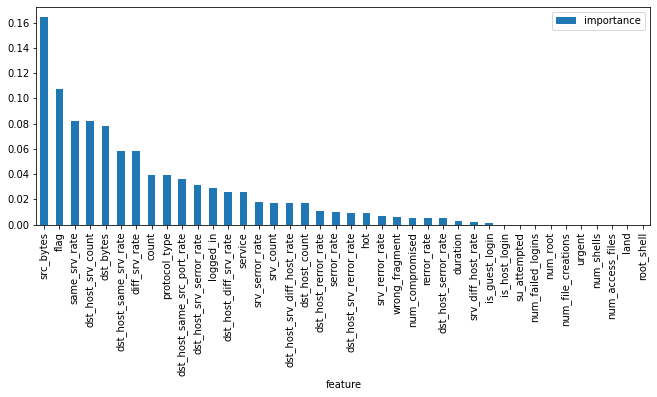

In [28]:
rfc = RandomForestClassifier();

# fit random forest classifier on the training set
rfc.fit(train_x, train_y);

# extract important features
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':train_x.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [29]:
# create the RFE model and select 10 attributes
rfe = RFE(rfc, n_features_to_select=15)
rfe = rfe.fit(train_x, train_y)

# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), train_x.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['src_bytes',
 'dst_bytes',
 'logged_in',
 'count',
 'srv_count',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'protocol_type',
 'service',
 'flag']

In [30]:
# here i am defining my performance metrics to check the performance of the model
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 3*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [31]:
a = [i[0] for i in feature_map]

train_x = train_x.iloc[:,a]
test_df = test_df.iloc[:,a]

train_x.shape

(25192, 15)

In [32]:
ica = FastICA(n_components=256, 
              max_iter=500, 
              random_state=1000)
ica.fit(train_x)

FastICA(max_iter=500, n_components=256, random_state=1000)

In [36]:
X_train,X_test,Y_train,Y_test = train_test_split(train_x,train_y,train_size=0.70, random_state=2)
input_shape = [X_train.shape[1]]

# Initialising the ANN
model_ann = Sequential()

# Adding the input layer and the first hidden layer
model_ann.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu', input_dim = 15))

# Adding the second hidden layer
model_ann.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
model_ann.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
model_ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = METRICS)

# Fitting the ANN to the Training set
history = model_ann.fit(X_train, Y_train, batch_size = 10, epochs = 10)

Epoch 1/10
1764/1764 [==============================] - 7s 2ms/step - loss: 0.2347 - accuracy: 1.0000 - precision: 0.8899 - recall: 0.9458 - auc: 0.9657 - f1_score: 1.3632
Epoch 2/10
1764/1764 [==============================] - 4s 2ms/step - loss: 0.1573 - accuracy: 1.0000 - precision: 0.9338 - recall: 0.9558 - auc: 0.9822 - f1_score: 1.4075
Epoch 3/10
1764/1764 [==============================] - 3s 2ms/step - loss: 0.1426 - accuracy: 1.0000 - precision: 0.9429 - recall: 0.9639 - auc: 0.9849 - f1_score: 1.4224
Epoch 4/10
1764/1764 [==============================] - 4s 2ms/step - loss: 0.1364 - accuracy: 1.0000 - precision: 0.9454 - recall: 0.9649 - auc: 0.9861 - f1_score: 1.4231
Epoch 5/10
1764/1764 [==============================] - 3s 2ms/step - loss: 0.1307 - accuracy: 1.0000 - precision: 0.9494 - recall: 0.9683 - auc: 0.9873 - f1_score: 1.4310
Epoch 6/10
1764/1764 [==============================] - 3s 2ms/step - loss: 0.1276 - accuracy: 1.0000 - precision: 0.9505 - recall: 0.9705 -

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96      3385
         1.0       0.98      0.95      0.97      4173

    accuracy                           0.96      7558
   macro avg       0.96      0.97      0.96      7558
weighted avg       0.97      0.96      0.96      7558



0.9646731939666578

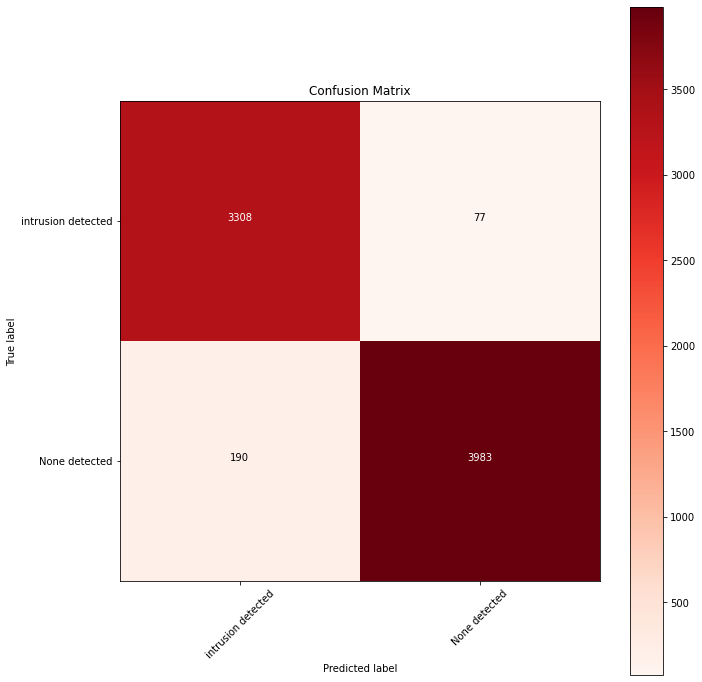

In [42]:
y_pred1 = model_ann.predict(X_test).reshape(-1)
#print (y_pred1[:5])
y_pred1 = np.round(y_pred1)
print ( classification_report(y_pred1, Y_test))
cm1 = confusion_matrix(y_pred1, Y_test)

def plot_confusion_matrix1(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Reds):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
target_names = ["intrusion detected", "None detected"]
plot_confusion_matrix1(cm1, target_names, normalize=False, title='Confusion Matrix')
accuracy_score(Y_test, y_pred1)

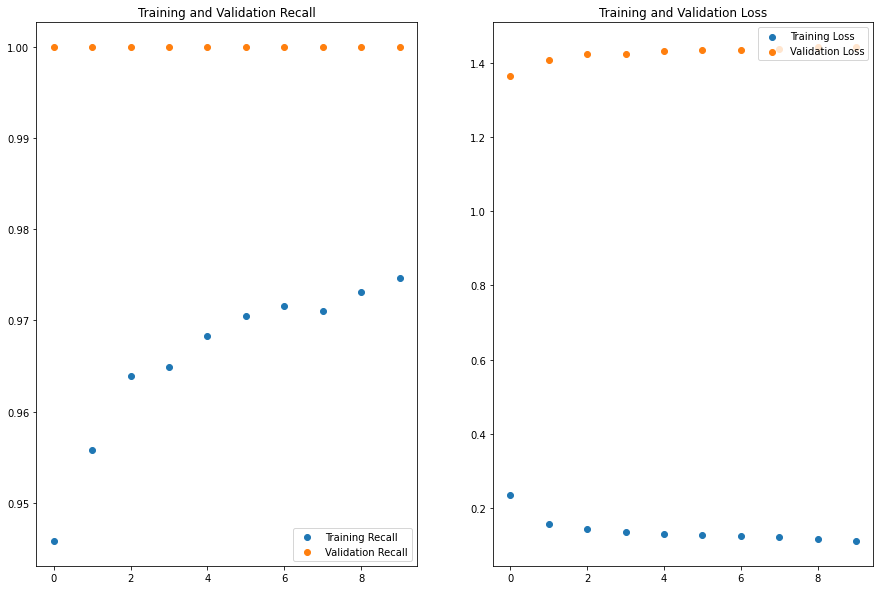

In [38]:
acc = history.history['recall']
val_acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['f1_score']
epochs_range = range(len(history.history['f1_score']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.scatter(epochs_range, acc, label='Training Recall')
plt.scatter(epochs_range, val_acc, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')
plt.subplot(1, 2, 2)
plt.scatter(epochs_range, loss, label='Training Loss')
plt.scatter(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

roc_auc_score for ANN:  0.9633588651643304


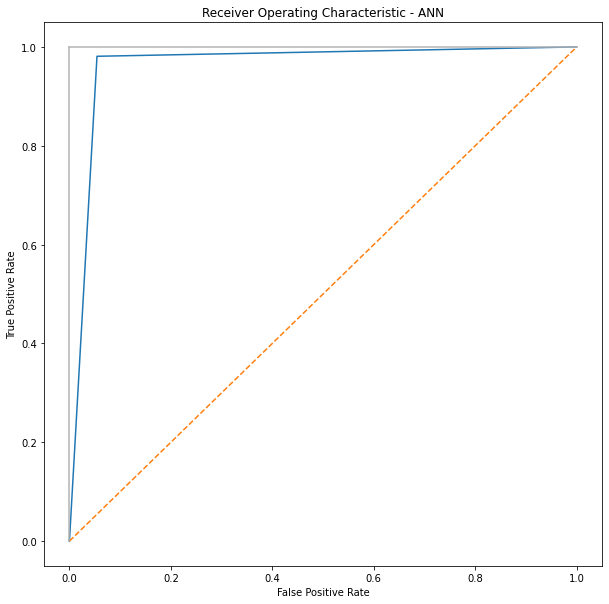

In [46]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(Y_test, y_pred1)
print('roc_auc_score for ANN: ', roc_auc_score(Y_test, y_pred1))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - ANN')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [47]:
model_rnn = Sequential()
model_rnn.add(BatchNormalization(input_shape=input_shape))
#model1.add(SimpleRNN(128))
model_rnn.add(Dropout(0.3))
model_rnn.add(Flatten()) # flatten out the layers
model_rnn.add(Dense(512,activation='relu'))
model_rnn.add(BatchNormalization())
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(512,activation='relu'))
model_rnn.add(BatchNormalization())
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(1, activation='sigmoid'))
model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 15)               60        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 15)                0         
                                                                 
 flatten (Flatten)           (None, 15)                0         
                                                                 
 dense_3 (Dense)             (None, 512)               8192      
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 512)              

In [49]:
#X_train.shape[1]
model_rnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = METRICS)
history = model_rnn.fit(X_train, Y_train, batch_size = 10, epochs = 10)

Epoch 1/10
1764/1764 [==============================] - 18s 8ms/step - loss: 0.2589 - accuracy: 1.0000 - precision: 0.9313 - recall: 0.9470 - auc: 0.9775 - f1_score: 1.3590
Epoch 2/10
1764/1764 [==============================] - 14s 8ms/step - loss: 0.2112 - accuracy: 1.0000 - precision: 0.9192 - recall: 0.9310 - auc: 0.9716 - f1_score: 1.3767
Epoch 3/10
1764/1764 [==============================] - 12s 7ms/step - loss: 0.2017 - accuracy: 1.0000 - precision: 0.9224 - recall: 0.9357 - auc: 0.9742 - f1_score: 1.3843
Epoch 4/10
1764/1764 [==============================] - 12s 7ms/step - loss: 0.1889 - accuracy: 1.0000 - precision: 0.9303 - recall: 0.9407 - auc: 0.9776 - f1_score: 1.3944
Epoch 5/10
1764/1764 [==============================] - 12s 7ms/step - loss: 0.1802 - accuracy: 1.0000 - precision: 0.9296 - recall: 0.9394 - auc: 0.9796 - f1_score: 1.3935
Epoch 6/10
1764/1764 [==============================] - 13s 7ms/step - loss: 0.1834 - accuracy: 1.0000 - precision: 0.9304 - recall: 0.

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96      3385
         1.0       0.98      0.95      0.97      4173

    accuracy                           0.96      7558
   macro avg       0.96      0.97      0.96      7558
weighted avg       0.97      0.96      0.96      7558



0.9646731939666578

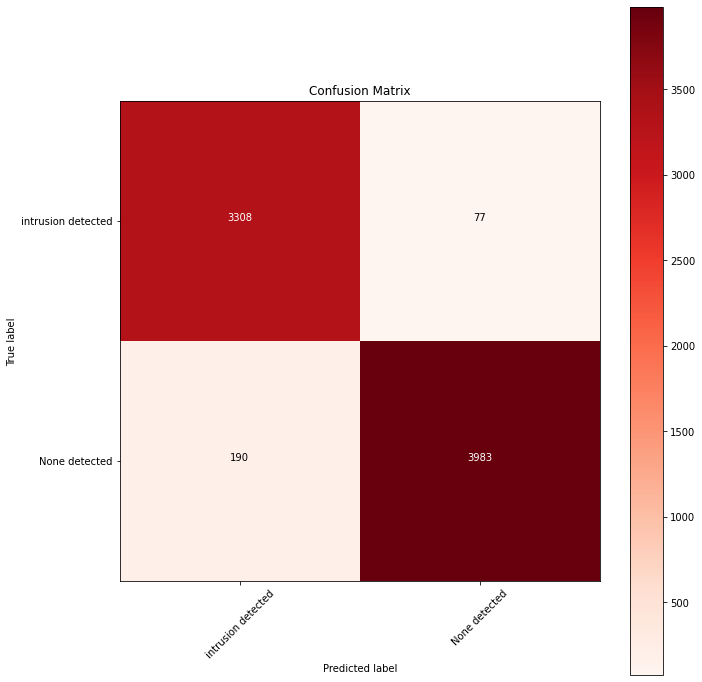

In [50]:
y_pred2 = model_ann.predict(X_test).reshape(-1)
#print (y_pred1[:5])
y_pred2 = np.round(y_pred1)
print ( classification_report(y_pred2, Y_test))
cm1 = confusion_matrix(y_pred2, Y_test)

def plot_confusion_matrix1(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Reds):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
target_names = ["intrusion detected", "None detected"]
plot_confusion_matrix1(cm1, target_names, normalize=False, title='Confusion Matrix')
accuracy_score(Y_test, y_pred2)

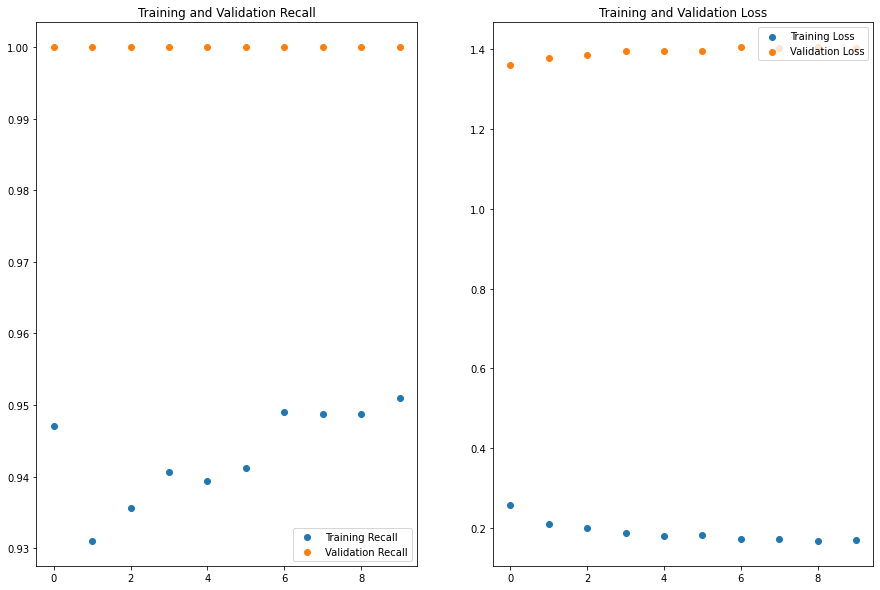

In [51]:
acc = history.history['recall']
val_acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['f1_score']
epochs_range = range(len(history.history['f1_score']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.scatter(epochs_range, acc, label='Training Recall')
plt.scatter(epochs_range, val_acc, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')
plt.subplot(1, 2, 2)
plt.scatter(epochs_range, loss, label='Training Loss')
plt.scatter(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

roc_auc_score for RNN:  0.9633588651643304


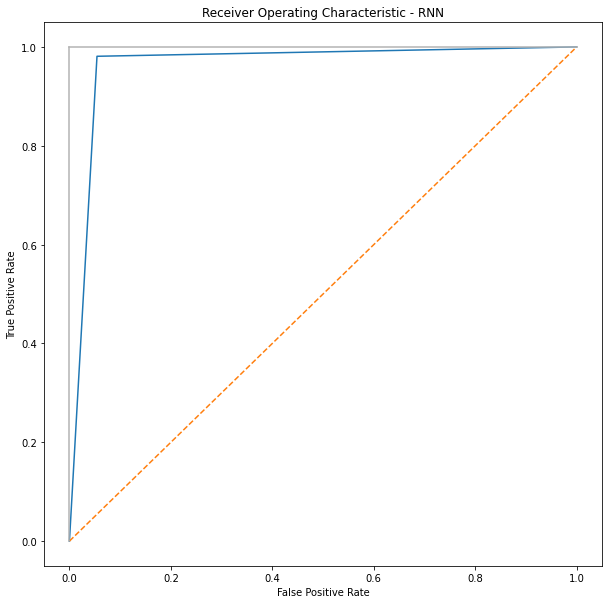

In [52]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(Y_test, y_pred2)
print('roc_auc_score for RNN: ', roc_auc_score(Y_test, y_pred2))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - RNN')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()